<a href="https://colab.research.google.com/github/elliotpaquette/elliotpaquette/blob/master/SGD_GD_experiment_ICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this file**, we demonstrate the predictions for the training and testing of a random features regression for:

1.   Gaussian linear regression
2.   car/plane regression on CIFAR-5m (this will require some modification to account for loading the dataset -- a suggested method using the google Cloud is provided)

This code generates the pictures used in the paper, showing the agreement between SGD and the Volterra prediction.


In [ ]:
import numpy as np
import scipy as sp
import numpy.random as npr
from scipy.sparse import diags as spdiags
from scipy.sparse import linalg as splinalg
from scipy.signal import fftconvolve as fftconvolve
from scipy.integrate import quad
from scipy.integrate import fixed_quad
from scipy.integrate import solve_ivp

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#SGD & Volterra code

This code is for running SGD and for running the Volterra code

Runs the sgd algorithm to solve the least squares problem $Ax = b$. 

In [ ]:
def sgd_lsq_ridge( A, b, t_max, ridge=0.0, 
             initial_state = [], loss=lambda x: (1/2)*np.sum( (A@x-b)**2), 
             gamma=-1, oversample=1, m=1.0):
  """Runs the sgd algorithm to solve the least squares problem Ax=b.
  The special case of gamma_1 =0 recovers SGD.

  Parameters
  ----------
  A : matrix
      The data matrix (2d-array) of some shape (n,d)
  b : vector
      The target vector
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  ridge : float, optional
      The strength of the ridge regularization
  initial_state : vector, optional
      The initial state vector of the algorithm.  Defaults to 
      iid Gaussian of expected norm-squared d/(2*n).
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  oversample: int, optional
      return additional losses, by a multiple of oversample 
      (note integer division is performed, so every n//oversample is returned)
      Pass 'adaptive' to use exponentially spaced.
  m: float, optional
      The adaptive step parameter.
  

  Returns
  -------
  x: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  times: numpy.array(int)
      the iteration counts at which the sgd was sampled
  """

  n, d = A.shape
  adaptivestep=False
  adaptivesample=True
  TL = lambda x: (1/2)*np.sum( (A@x-b)**2)

  steps = (n * t_max)#.astype(int)
  
  losses = []
  gammas = []
  times = []

  if (len(initial_state)==0):
    initial_state = npr.randn(d)/ (np.sqrt(2*n))
  x = initial_state  

  if oversample=='adaptive':
    adaptivesample = True
    oversample = 10

  tnaught = TL(x)
  GR = lambda A,x,b,ridge, n : A * (A.dot(x) - b) + (ridge/n)*x

  

  for t in range(steps):
    i = npr.randint(0,n, size =1)[0]
    grad_i = GR(A[i],x,b[i],ridge,n)
    
    if adaptivesample:
      if t % oversample == 0:
#      print("grad-norm = {}".format(np.linalg.norm(grad_i)))
 #       print("norm of grad_i={}, x={}, mean of a={}".format(tf.linalg.norm(grad_i),tf.linalg.norm(x),tf.reduce_sum(A[i])))

        oversample = (oversample*11)//10
        losses.append(loss(x))
        times.append(t)        
    elif t % (n//oversample) == 0:
      losses.append(loss(x))
      times.append(t)
    if (adaptivestep) and (t % n == 0):
      Gamma += gamma
      tz = TL(x)
# This adaptive stepsize is the other solution of the variational problem
#      gamma = 1./(np.exp(Gamma * (m+ridge)*0.666)*np.power(tz/tnaught,0.333))
      gamma = 2./(0.75 + np.sqrt(0.5625 + np.exp(2*Gamma * (ridge+m))*tz/tnaught))
      gammas.append(gamma)
    x = x - gamma * grad_i
  if (adaptivestep):
    return x, np.array(losses), np.array(gammas)
  return x, np.array(losses), times

Runs the sgd algorithm to solve the least squares problem $Ax = b$ using tensorflow. 

In [ ]:
def tfs_sgd_lsq_ridge( dtpair, steps, ridge=0.0, 
             initial_state = [], loss= lambda x : tf.constant([0.0]), 
             gamma=-1, oversample=1):
  """Runs the sgd algorithm to solve the least squares problem Ax=b.
  The special case of gamma_1 =0 recovers SGD.

  Parameters
  ----------
  dtpair : function
      This should return a pair (a, b) of training data
  steps : int
      The number of iterations to run
  ridge : float, optional
      The strength of the ridge regularization (per iteration)
  initial_state : vector, optional
      The initial state vector of the algorithm.  Defaults to 
      iid Gaussian of expected norm-squared d/(2*n).
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  ridge: float, optional
      The ridge parameter to pass.
  oversample: int, optional
      return additional losses, by a multiple of oversample 
      (note integer division is performed, so every d//oversample is returned).
      Pass 'adaptive' for exponentially spaced samples.
  

  Returns
  -------
  x: numpy.array(float)
      the best fit vector x
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  times: numpy.array(int)
      the iteration counts at which the sgd was sampled
  """

  a = dtpair()[0]
  minibatch = a.shape[0]
  d = a.shape[1]
  print("Working with batch={}, d={}".format(minibatch,d))
  adaptivesample=False
  #TL = lambda x: (1/2)*np.sum( (A@x-b)**2)
  
  losses = []
  gammas = []
  times = []

  if (len(initial_state)==0):
    initial_state = npr.randn(d)/ (np.sqrt(2*d))
  x = tf.convert_to_tensor(initial_state,dtype=tf.float32)

  if oversample=='adaptive':
    adaptivesample = True
    oversample = 10

  #GR = lambda A,x,b,ridge : A * (A.dot(x) - b) + ridge*x
  #GR = lambda A,x,b,ridge : A[0] * (tf.tensordot(A,x,axes=[1,0]) - b) + ridge*x
  GR = lambda a,x,b,ridge : gamma*(tf.einsum('ji,jk,k',a,a,x)-tf.einsum('ji,j',a,b)+(ridge*minibatch)*x)

  a,b = dtpair()
  print("shapes of a {}, x {}, b {}, ridge {}".format(a.shape,x.shape,b.shape,ridge))
  

  for t in range(steps):
    a,b = dtpair()
    grad_i = GR(a,x,b,ridge)
    
    if adaptivesample:
      if t % oversample == 0:
        #print("norm of grad_i={}, x={}, mean of a={}".format(tf.linalg.norm(grad_i),tf.linalg.norm(x),tf.reduce_sum(a)))
        oversample = (oversample*11)//10
        losses.append(loss(x).numpy())
        times.append(t*minibatch)        
    elif t % (oversample) == 0:
      losses.append(loss(x))
      times.append(t*minibatch)

    x = tf.subtract(x,grad_i)
    #x = x - gamma * grad_i

  return x, np.array(losses), times

Runs Picard iteration to approximate a convolution Volterra equation.

In [ ]:
def picard_volterra(f, K, t_max, n_grid):
  """Runs Picard iteration to approximate a convolution Volterra equation
  sol = f + K*sol, where * denotes convolution, 
  and where K is assumed to be positive.

  Parameters
  ----------
  f : callable
      Forcing function that takes as input a vector of times to be evaluated
  K : callable
      Convolution kernel that takes as input a vector of times to be evaluated
  t_max : float
      The number of epochs 
  n_grid : int
      The number of grid points

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """

  t_grid = tf.linspace(0, t_max, n_grid)
  delta = t_max/n_grid
  I = delta*K(t_grid)
  F = f(t_grid)

  danger =  tf.reduce_max(I).numpy() 
  if danger > 0.001:
    print("Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is " + str(danger))
      
  
  #tf.reduce_sum()
  knorm = tf.reduce_sum(I).numpy()
  print( "kernel norm computed as "+str(knorm))

  loops = int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  sol = tf.zeros(n_grid, dtype=tf.float64)
  for i in range(loops):
    sol = F + fftconvolve(sol, I, mode="full")[0:n_grid]
  return t_grid, sol
  

Generates the Volterra model for SGD for a list of eigenvalues eiglist. This code uses tensorflow to speed up the computations

In [ ]:
def tf_empirical_volterra_sgd(eiglist, t_max, n_grid, initial_state, UTb, ridge = 0.0, gamma=-1, batch=10000):
  """Generates the Volterra model for SGD for a list of eigenvalues eiglist

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T).
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of 
      the eigenvalues
  batch: int, optional
      The max number of time points to use in a batch.

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the convolution Volterra equation at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n_eig= len(eiglist)

  if n_grid % batch != 0:
    if n_grid < batch:
      batch = n_grid
    else:
      raise NameError('batch size should divide n_grid or be larger than n_grid')

  if gamma==-1:
    gamma = len(eiglist)/np.sum(eiglist)


  n = n_eig
  d = len(initial_state)
  r=min(n,d)

  tfeig = tf.constant(eiglist[0:r], dtype=tf.float64)
  tfUTb = tf.constant(UTb[0:r], dtype=tf.float64)
  tfIS = tf.constant(initial_state[0:r], dtype=tf.float64)

  def forcing(times):
    tftimes = tf.constant(times, dtype=tf.float64)
    ntimes = len(times)
    tflist = tf.split(tftimes, ntimes//batch)
    flist = []
    for ts in tflist:
      eigtimes = (tf.tensordot(-1.0*gamma*(tfeig+ridge),ts,axes=0))
      ftally = tf.einsum('i,i,ij', 0.5*(tfIS**2),tfeig, tf.math.exp(2.0*eigtimes))
      pt=tf.einsum('i,ij->ij', tfeig/(tfeig+ridge), 1.0-tf.math.exp(eigtimes))
      ftally += 0.5*tf.reduce_sum(tf.einsum('i,ij->ij', (tfUTb),pt-1.0)**2,axis=0)
      if n > d:
        ftally += (0.5*np.sum(UTb[-(n-d):]**2))
      flist.append(ftally)
    
    return tf.reshape(tf.squeeze(flist),[ntimes])
  
  def K(t):
    tft = tf.constant(t, dtype=tf.float64)
    ntimes = len(t)
    tflist = tf.split(t, ntimes//batch)
    flist = []
    for ts in tflist:
      et = (tf.tensordot(-2.0*gamma*(tfeig+ridge),ts,axes=0))
      flist.append(tf.einsum('i,ij', (gamma**2/n)*tfeig**2, tf.math.exp(et)))
    
    return tf.reshape(tf.squeeze(flist),[ntimes])

  t_grid, sol = picard_volterra(forcing,K,t_max,n_grid)


  return t_grid, sol



Generates the generalization error in the Volterra model for SGD with parameters given in the spectral basis. This code uses tensorFlow.

In [ ]:
def tf_empirical_volterra_g_sgd(eiglist, t_max, n_grid, initial_state, UTb,
                             S,h,c, 
                             ridge = 0.0, gamma=-1, batch=10000
                             ):
  """Generates the generalization error in the Volterra model for SGD, with parameters
  given in the spectral basis

  Parameters
  ----------
  eiglist : vector
      The eigenvalues of Gauss--Newton matrix of the least squares problem,
      n is the number of eigenvalues (AA^T), in DECREASING ORDER.
  t_max : float
      The number of epochs (algorithm will run t_max * n steps)
  n_grid : int
      The number of grid points
  initial_state : vector
      The initial state vector in the eigenbasis (V^T x_0)
  UTb: vector
      The target vector in the spectral basis, i.e. U^Tb where A=U*Sigma*V^T.
  S,h,c: matrix,vector,float
      The S,h,c are the terms in the generalization functional, g, such that
      g(V^T x_t) = 0.5*x_t^T V S V^T x_t + h^T V^T x_t + c (see eq (104))
  ridge : float, optional
      The strength of the ridge regularization
  gamma: float, optional
      (learning rate) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A|| -- Frobenius squared of ||A|| is also the sum of 
      the eigenvalues
  batch: int, optional
      The max number of time points to use in a batch.      


  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the generalization error at the time steps
  """
  lmin = np.min(eiglist)
  lmax = np.max(eiglist)
  n = len(eiglist)
  d = len(initial_state)

  if n_grid % batch != 0:
    if n_grid < batch:
      batch = n_grid
    else:
     raise NameError('batch size should divide n_grid or be larger than n_grid')

  if gamma==-1:
    gamma = n/np.sum(eiglist)

  t_grid, f1 = tf_empirical_volterra_sgd(eiglist,t_max,n_grid,initial_state,UTb,ridge,gamma,batch)
  f2=f1.numpy()

  eiglist = np.pad(eiglist, (0,max(d-n,0)))
  eiglist = eiglist[0:d]
  UTb = np.pad(UTb, (0,max(d-n,0)))
  UTb = UTb[0:d]

  tft = tf.cast(t_grid, tf.float32)
  tfeig = tf.constant(eiglist, dtype=tf.float32)
  tfUTb = tf.constant(UTb, dtype=tf.float32)
  tfIS = tf.constant(initial_state, dtype=tf.float32)
  tfS = tf.constant(S, dtype=tf.float32)
  
  L = tf.linalg.cholesky(tfS + 1E-09*tf.eye(d,dtype=tf.float32))
  SUTb = tfUTb * tf.math.sqrt(tfeig) / (tfeig + ridge+1E-09)

  tflist = tf.split(tft, n_grid//batch)
  flist = []
  flist2 = []
  for ts in tflist:
    eigtimes = (tf.tensordot(-1.0*gamma*(tfeig+ridge),ts,axes=0))
    #ftally = tf.einsum('i,ij', 0.5*(tfIS**2)*tfeig, tf.math.exp(2.0*eigtimes))

    EM = tf.math.exp(eigtimes)
    EM1 = (tf.ones((d,batch),dtype=tf.float32) - EM)

    # ||x_0 * EM(t) * L||^2
    l1 = 0.5*tf.reduce_sum(tf.einsum('i,ij,ik', tfIS, EM, L, optimize='optimal')**2,axis=1)

    # ||SUTb^T * EM1(t) * L||^2
    l2 = 0.5*tf.reduce_sum(tf.einsum('i,ij,ik', SUTb, EM1, L, optimize='optimal')**2,axis=1)

    # SUTb^T * EM1(t) * h
    l3 = tf.einsum('i,ij,i', SUTb, EM1, h, optimize='optimal')

    #This is the convolution term, the final in (104).  
    #igrand = np.sum([s*x*np.exp(-2*gamma*(x+ridge)*t_grid) for (s,x) in zip(np.diag(S),eiglist)],axis=0)
    igrand = tf.einsum('i,ij', tf.linalg.diag_part(tfS)*tfeig, EM**2).numpy()
    igrand = igrand * (gamma**2/n) * (t_max/( n_grid+1))

    gerror = l1+l2+l3+c
    flist.append(gerror)
    flist2.append(igrand)

  gerror = tf.reshape(tf.squeeze(flist),[n_grid]).numpy()
  igrand = tf.reshape(tf.squeeze(flist2),[n_grid]).numpy()

  #Compute convolution term and add a trapezoid rule correction
  l4 = fftconvolve(igrand, f2, mode="full")[0:n_grid] + (
      -0.5*igrand[0]*f2
      -0.5*igrand*f2[0]
  )

  return t_grid, gerror+l4


Demonstrate the empirical losses of the Volterra equation with empirical eigenvalues vs sgd on random features data.

Given X (''data'') ($n \times n_0$ -- n samples of data dimension $n_0$, which are standardized), we multiply by a weight matrix W (''inner layer weights'') ($n_0 \times d$ -- un-normalized).  Then $XW$ is $n \times d$.  We apply an activation function $\psi$ to each entry of $XW$.  We assume that $\psi$ is also standarized, in that $\mathbb{E}( \psi(Z) ) =0$ and  $\mathbb{E}( \psi(Z)^2 ) = 1/d$ for $Z \sim N(0,1).$

Example (1):
The linear case is $\psi(x) = x/\sqrt{d}$.

Example (2):
The ReLU case is $\frac{(\max\{x,0\} - (1/\sqrt{2\pi}))}{\sqrt{d}\sqrt{ 1/2 - 1/(2\pi)}}$

The ground truth is a linear model $x \mapsto x^T\beta$ for $x \in \mathbb{R}^{n_0}$ and $\beta \in \mathbb{R}^{n_0}$.  We suppose that $\beta$ are iid $N(0,1)$.  Then we draw a $b = X \beta$.

The first cell below generates the sample covariance matrix and the sample mean needed to to evaluate the test error.


In [ ]:
def tf_stdz_relu(M):
  """Generate a gaussian-mean-0, gaussian-variance-1 relu of a matrix
  Parameters
  ----------
  M : vector
      The data to be relued
  """ 
  a=(1.0/np.sqrt(2*np.pi))
  b=np.sqrt(0.5 - 1.0/(2*np.pi))
  return (tf.nn.relu(M)-a)/b
#  return (tf.maximum(M,0.0)-(1.0/np.sqrt(2*np.pi)))/np.sqrt(0.5 - 1.0/(2*np.pi))


#Gaussian experiment

Gaussian linear regression test loss.  Runs a series of experiments of increasing size (n_base*n_mult) in a fixed dimension, of an idealized Gaussian experiment.

In [ ]:
n0 = 28*28
d= 2000 #number of random features
n_grid=10000
n_base = 1000 #datapoints to keep
n_mult = [2,3,5]#,8,12,16,24]
t_max = 80000 #iterations
#n_mult = [6,10,16,24,40,60]
#t_max = 600000 #iterations
gamma=0.8
ridge = 0.01
eta = 0.2
os=10 #show os datapoints per epoch


beta = npr.randn(d)/np.sqrt(d)

#nmax = max(n_list)

actual = beta
SigmaPsi = np.eye(d)
u=actual
c=0.5*np.sum(actual**2)
test2loss= lambda x: (0.5)*np.sum((x - beta)**2)

t_sgdtimes = []
t_sgds= []
t_tgrids = []
t_vemps = []

for nmult in n_mult:
    #datapairs
  n = n_base*nmult

  #Data
  A = npr.randn(n,d)/np.sqrt(d)
  b = A@beta + eta*npr.randn(n)/np.sqrt(d)

  #initialization
  ist = np.zeros(d)/np.sqrt(d)


  U, s, Vh = np.linalg.svd(A, full_matrices=False)
  eigs = np.pad(s**2, (0,max(n-d,0)))
  UTb = U.transpose() @ b

  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d: 
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  sgd_sol, sgd_test2_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,
                          loss=test2loss,
                          gamma=gamma,
                          oversample='adaptive')
  t_sgdtimes.append(sgd_times)
  t_sgds.append(sgd_test2_cs)
  #These are used for the volterra computation
  S = Vh@SigmaPsi@Vh.transpose()
  h = -Vh@u.transpose()
  
  #Second way of getting the training loss, using the empirical_volterra_g_sgd41
  t_grid, v_emp = tf_empirical_volterra_g_sgd(eigs,t_max//n,n_grid,
                                          Vh@ist,UTb,S,h,c,ridge,
                                          gamma=gamma)
  t_tgrids.append(t_grid)
  t_vemps.append(v_emp)


Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is 0.005121674259315229
kernel norm computed as 0.39891703239633663
will use 11 iterations
Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is 0.004162459503534871
kernel norm computed as 0.3994473995243009
will use 11 iterations
Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is 0.003582798308842698
kernel norm computed as 0.39996403049292406
will use 11 iterations


In [ ]:
a=np.sqrt(d)
def strlin():
  x = npr.randn(d)/a
  return tf.expand_dims(tf.constant(x,dtype=tf.float32),0), tf.constant([x.dot(beta)+eta*npr.randn()/a],dtype=tf.float32)
#initialization
ist = np.zeros(d)/np.sqrt(d)
s_sol, s_test_cs, s_times = tfs_sgd_lsq_ridge( strlin, t_max, ridge=0,#1.0E-4, 
             initial_state = ist, loss=lambda x: (1/2)*(tf.reduce_sum( (x-beta)**2)), 
             gamma=gamma, oversample='adaptive')

Working with batch=1, d=2000
shapes of a (1, 2000), x (2000,), b (1,), ridge 0


In [ ]:
eigs = np.ones(d)
S = np.eye(d)
h = -beta
c = 0.5*(np.sum(beta**2))
#UTb = np.ones(d)*np.sqrt(1+eta**2)/np.sqrt(d)
UTb = 1.0*beta#/np.sqrt(d)#*np.sqrt(1+eta**2)/np.sqrt(d)
#Utb = beta

UTb = np.pad(UTb,(0,1), mode='constant', constant_values=(0,eta))
eigs = np.pad(eigs,(0,1), mode='constant', constant_values=(0,0))

#Second way of getting the training loss, using the empirical_volterra_g_sgd41
st_tgrid, sv_temp = tf_empirical_volterra_g_sgd(eigs,t_max//d,n_grid,
                                        ist,UTb,S,h,c,ridge=0,#d*1.0E-4,
                                        gamma=gamma)

Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is 0.0025587206396801908
kernel norm computed as 0.4010408450464247
will use 11 iterations


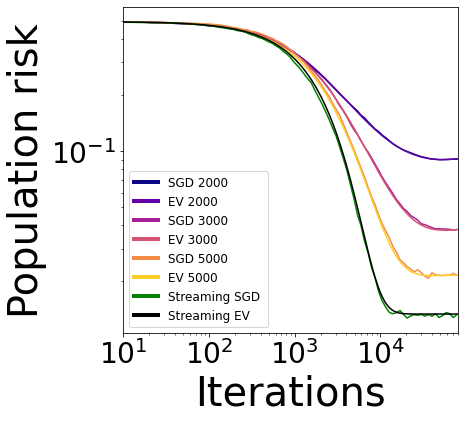

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(n_mult))))

for (idx,nmult) in enumerate(n_mult):
  n=nmult*n_base
  #print(idx)
  plt.plot(t_sgdtimes[idx], t_sgds[idx], label="SGD "+str(n),
           c=next(colors))
  plt.plot(t_tgrids[idx]*nmult*n_base, t_vemps[idx], label="EV "+str(n),c=next(colors))

plt.plot(s_times, s_test_cs, label="Streaming SGD ",
         c='green')
plt.plot(st_tgrid*d, sv_temp, label="Streaming EV",
         c='black')

plt.xlim([10,t_max])
leg = plt.legend(bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize='12')
plt.xticks(Fontsize='28')
plt.yticks(Fontsize='28')
plt.xlabel('Iterations',fontsize='40')
plt.ylabel('Population risk',fontsize='40')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

fig.savefig("GaussianLinearRegression_test.pdf")

#CIFAR-5m

The cells below are one method to mount CIFAR-5m, by placing the data onto the google cloud.  This requires some setup.  You may instead prefer to test the code below with CIFAR-10.  Choose the appropriate code below.a

In [ ]:
from google.colab import auth
auth.authenticate_user()

#IF you want all da data, set the below to True
LoadAll = False

##REPLACE BY YOUR PROJECT ID
project_id = 'c5mp-349503'
!gcloud config set project {project_id}

Updated property [core/project].


Code to copy the CIFAR-5m data to a BUCKET (this only needs to be done once).

In [ ]:
import uuid
bucket_name = f'c5mp-349503-{uuid.uuid1()}'
!gsutil mb gs://{bucket_name}
!gsutil cp gs://gresearch/cifar5m/part0.npz gs://c5mp-349503-f0106d74-cdb6-11ec-bc3e-0242ac1c0002/tmp/cifar5mp0.npz


Creating gs://c5mp-349503-4003bb68-dbf6-11ec-a52a-0242ac1c0002/...
Copying gs://gresearch/cifar5m/part0.npz [Content-Type=application/octet-stream]...
- [1 files][  2.9 GiB/  2.9 GiB]                                                
Operation completed over 1 objects/2.9 GiB.                                      


Mount the data

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

!mkdir tfs
##REPLACE BY THE BUCKET
!gcsfuse --implicit-dirs c5mp-349503-f0106d74-cdb6-11ec-bc3e-0242ac1c0002 tfs

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  31320      0 --:--:-- --:--:-- --:--:-- 31320
OK
56 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 11.5 MB of archives.
After this operation, 27.2 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.1_amd64.deb ...
Unpacking gcsfuse (0.41.1) ...
Setting up gcsfuse (0.41.1) ...
2022/05/25 06:45:56.300161 Start gcsfuse/0.41.1 (Go version go1.17.6) for app "" using mount po

Load the CIFAR-5m data.  Modify the lines below to use 

In [ ]:
data = np.load('/content/tfs/tmp/cifar5mp0.npz')
c5m = tf.data.Dataset.from_tensor_slices((data['X'], data['Y']))
if LoadAll==True:
  for j in range(1,5):
    data = np.load('/content/tfs/tmp/cifar5mp{}.npz'.format(j))
    c5m = c5m.concatenate(tf.data.Dataset.from_tensor_slices((data['X'], data['Y'])))

Gets just the car/plane data from the full CIFAR-5m dataset.  The first part generates the 

In [ ]:
c5_car = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(100000)
c5_car = c5_car.map(lambda x, y: (tf.cast(x, tf.float32), y))
c5_car = c5_car.map(lambda x, y: (tf.reshape(x,[-1,32*32*3]), y))

num_batches = 2
it = iter(c5_car)
scov = tf.zeros([32*32*3,32*32*3],dtype=tf.float32)
for k in range(num_batches):
  print("On batch k={}".format(k))
  (x_test, y_test) = it.get_next()
  flat = x_test
  means= tf.reduce_mean(flat,0)
  flat -= means
  flat = tf.linalg.normalize(flat,axis=1)[0]
  scov += num_batches * tf.einsum('ij,ik',flat,flat)


On batch k=0
On batch k=1
On batch k=2
On batch k=3


OutOfRangeError: ignored

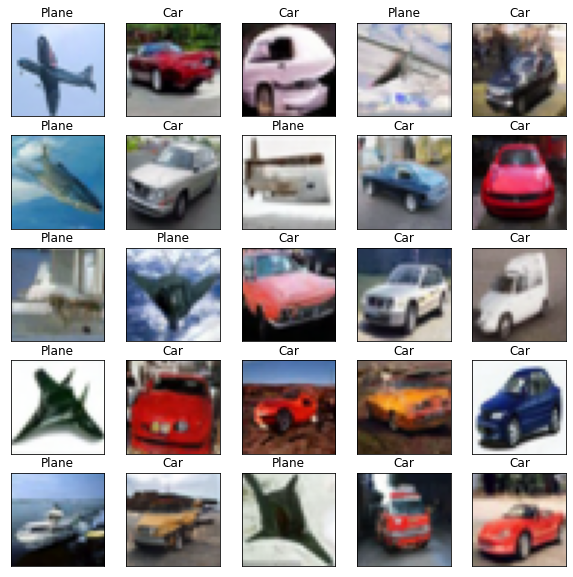

In [ ]:
c5m01 = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(200)
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 10))
rows, columns = 5, 5
c5m01 = c5m01.shuffle(1)
imlist = next(c5m01.as_numpy_iterator())
label_names = ["Plane", "Car"]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imlist[0][i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}".format(label_names[imlist[1][i-1]]))


#Experiments-CIFAR-5m

Run to generate the CIFAR-5m experiments

Generate the test loss function for random features plane/car regression with a random matrix $W_{tf}$

In [ ]:
n0 = 32*32*3
d = 6000
Wtf = tf.random.normal( (n0, d), dtype=tf.float32 )

#generate test covariance
nuclear=200000 #big batch size -- system-memory limited
mininuke=10000 #smaller batch size -- GPU-memory limited
c5m01 = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(nuclear)
c5m01 = c5m01.map(lambda x, y: (tf.cast(x, tf.float32), y))
c5m01 = c5m01.shuffle(1)
it = iter(c5m01)
(x_test, y_test) = it.get_next()

flat = tf.reshape(x_test,(nuclear,n0))
means= tf.reduce_mean(flat,0)
flat -= means
flat = tf.linalg.normalize(flat,axis=1)[0]

#Wtf = tf.random.normal( (n0, d) )
flatz = tf.split(flat, nuclear//mininuke)
cov_stream = tf.zeros((d,d),tf.float32)
b_stream = (tf.cast(y_test % 2,tf.float32) - 0.5)
bz = tf.split(b_stream, nuclear//mininuke)
u_stream = tf.zeros((d),tf.float32)
for fs,bs in zip(flatz,bz):
  Atf_stream = tf_stdz_relu( tf.matmul(fs, Wtf) ) / np.sqrt(d)
  cov_stream += tf.einsum('ij,ik', Atf_stream, Atf_stream)/nuclear
  u_stream += tf.linalg.matvec(Atf_stream, bs, transpose_a=True) / nuclear

#Sknorm = tf.sqrt(tf.linalg.norm(bs)**2 -  tf.linalg.norm(SUTb)**2).numpy()

c_stream = 0.5*tf.linalg.norm(b_stream)**2 / nuclear


streamingloss = lambda x : (0.5*tf.einsum('i,ij,j',x,cov_stream,x)-tf.tensordot(x,u_stream,axes=1)+c_stream)

Generates the streaming loss

In [ ]:
L_stream = tf.linalg.cholesky(cov_stream)
v_stream = tf.linalg.triangular_solve(L_stream, tf.expand_dims(u_stream,1), lower=True)
v_stream = tf.squeeze(v_stream)

noise_stream = c_stream - 0.5 * tf.linalg.norm(v_stream)**2 

streamingloss2 = lambda x : 0.5 * tf.reduce_sum( ( tf.linalg.matvec(L_stream, x, transpose_a = True) - v_stream )**2 ) + noise_stream

streamingloss2_wrapper = lambda x : streamingloss2(tf.convert_to_tensor(x,dtype=tf.float32))


These are the variables to run for all runs(streaming, volterra, training, etc)

In [ ]:
n_grid= 4000000
vbatch = 1000
n_base = 1000 #datapoints to keep
n_mult = [4,6,10] #smaller picture 
#n_mult = [4,6,10,20,40] #this was used for the paper
t_max = 1000000 #1000000 #iterations
gamma=0.8
ridge = 0.01

1.   Runs the training loss for various fixed dataset sizes $n$
2.   Runs the empirical Volterra equation for the fixed dataset sizes $n$


In [ ]:
sgdtimes = []
sgdtrains= []
tgrids = []
vemps = []


for nmult in n_mult:
  #datapairs
  n = n_base*nmult

  c5m01 = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(n)
  c5m01 = c5m01.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
  c5m01 = c5m01.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
  it = iter(c5m01)
  (x_train, y_train)  = it.get_next()

  Xtf = x_train
  btf = y_train

  Atf = tf_stdz_relu( tf.matmul(Xtf, Wtf) ) / np.sqrt(d) #Wtf defined above

  #initialization
  ist = np.zeros(d)/np.sqrt(d)

  stf, Utf, Vtf = tf.linalg.svd(Atf, full_matrices=False)
  #U, s, Vh = np.linalg.svd(A, full_matrices=False)
  s = stf.numpy()
  eigs = np.pad(s**2, (0,max(n-d,0)))
  Vh = tf.transpose(Vtf).numpy()
  b = btf.numpy()
  A = Atf.numpy()
  
  UTb = tf.linalg.matvec(Utf,btf,transpose_a=True).numpy()
  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d: 
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  #SGD runs, training finite dimensional
  sgd_sol, sgd_train_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,gamma=gamma,oversample='adaptive')
  sgdtimes.append(sgd_times)
  sgdtrains.append(sgd_train_cs)

  #Volterra, training finite dimensional
  t_grid, v_emp = tf_empirical_volterra_sgd(eigs,t_max//n,n_grid,Vh@ist,UTb,ridge,gamma,batch=vbatch)
  
  tgrids.append(t_grid)
  vemps.append(v_emp)


Runs the code for streaming SGD

In [ ]:
#streaming data
minibatch=1

#Selects class and normalizes the data
c5m_s = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(minibatch)
c5m_s = c5m_s.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
c5m_s = c5m_s.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
#c5m_s = c5m_s.map(lambda x, y: ((tf.cast(x, tf.float32), tf.cast(y%2,tf.float32)-0.5)))

it = iter(c5m_s)

#Returns next sample
def strlin2():
  (a,b) = it.get_next()
  return tf_stdz_relu( tf.matmul(a, Wtf) ) / np.sqrt(d), b

#initialization
ist = np.zeros(d)/np.sqrt(d)
s_sol, s_train_cs, s_times = tfs_sgd_lsq_ridge( strlin2, t_max//minibatch, ridge=0.0, #0.1,#1.0E-4, 
             initial_state = ist, loss=streamingloss, 
             gamma=gamma, oversample='adaptive')

Runs the code that computes the Volterra equation for the streaming SGD

In [ ]:
stf, Vtf, Utf = tf.linalg.svd(L_stream, full_matrices=False) #Note Utf, Vtf reversed because need L^T svd
#U, s, Vh = np.linalg.svd(A, full_matrices=False)
s = stf.numpy()
eigs = s**2
Vh = tf.transpose(Vtf).numpy()
b = v_stream.numpy()
A = tf.transpose(L_stream).numpy()

#We need to include the constant noise_stream term into the S function as it appears in the noise of hSGD
UTb = tf.linalg.matvec(Utf, v_stream, transpose_a=True).numpy()
UTb = np.pad(UTb,(0,1), mode='constant', constant_values=(0, np.sqrt(2.0 * noise_stream) ))
eigs = np.pad(eigs,(0,1), mode='constant', constant_values=(0,0))

#Volterra, training finite dimensional: all the d adjustments are because the tf_empirical_vol. infers that the dimension of problem is d
st_grid, sv_emp = tf_empirical_volterra_sgd(eigs*d,t_max//d,n_grid,Vh@ist,UTb,ridge=0.00,gamma = gamma,batch=vbatch)
sv_emp = sv_emp.numpy()
st_grid = np.array(st_grid) * d


Plotting the training loss

In [ ]:

fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(n_mult))))
j = 0

for (idx,nmult) in enumerate(n_mult):
  n=nmult*n_base
  #print(idx)
  if j == 0:
    plt.plot(sgdtimes[idx], sgdtrains[idx]/n, label="SGD n = {:,}".format(n),
            c=next(colors), linewidth = 2)
    plt.plot(tgrids[idx]*nmult*n_base, vemps[idx]/n, label="Volterra n = {:,}".format(n),c=next(colors), linewidth = 2)
  else:
    plt.plot(sgdtimes[idx], sgdtrains[idx]/n, label="SGD {:,}".format(n),
            c=next(colors), linewidth = 2)
    plt.plot(tgrids[idx]*nmult*n_base, vemps[idx]/n, label="Volterra, {:,}".format(n),c=next(colors), linewidth = 2)
  j = j+1

plt.plot(np.array(s_times), s_train_cs, label="Streaming SGD ",
        c='green', linewidth = 2)

#plt.plot(np.array(s_times)*minibatch, s_train_cs, label="Streaming SGD ",
#         c='green')
plt.plot(st_grid, sv_emp, label="Streaming Volterra",
        c='black', linewidth = 2)

plt.xlim([10,t_max])
leg = plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize='15')
plt.xticks(Fontsize='15')
plt.yticks(Fontsize='15')
plt.xlabel('iterations',fontsize='15')
#plt.ylabel('Empirical risk, CIFAR 5m, RF',fontsize='40')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
plt.annotate("CIFAR-5m, Random Features", xy=(25, 50), xycoords='axes points', size=15, ha='left', va='top', bbox=dict(boxstyle='round, pad = 0.3', fc="none", edgecolor = 'gray'))
plt.grid()
axarr = plt.axes()
#axarr.set_ylabel("training, MNIST", fontsize = '40')
axarr.set_xlabel("iterations", fontsize = '20')

plt.title("Empirical risk", fontsize = '20')


The next series of code produces the population risk

In [ ]:
p_sgdtimes = []
p_sgdtrains= []
p_tgrids = []
p_vemps = []


for nmult in n_mult:
  #datapairs
  n = n_base*nmult

  c5m01 = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(n)
  c5m01 = c5m01.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
  c5m01 = c5m01.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
  it = iter(c5m01)
  (x_train, y_train)  = it.get_next()

  Xtf = x_train
  btf = y_train

  Atf = tf_stdz_relu( tf.matmul(Xtf, Wtf) ) / np.sqrt(d) #Wtf defined above

  #initialization
  ist = np.zeros(d)/np.sqrt(d)

  stf, Utf, Vtf = tf.linalg.svd(Atf, full_matrices=False)
  #U, s, Vh = np.linalg.svd(A, full_matrices=False)
  s = stf.numpy()
  eigs = np.pad(s**2, (0,max(n-d,0)))
  Vh = tf.transpose(Vtf).numpy()
  b = btf.numpy()
  A = Atf.numpy()


  
  UTb = tf.linalg.matvec(Utf,btf,transpose_a=True).numpy()
  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d: 
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  #SGD runs, test finite dimensional
  sgd_sol, sgd_train_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,
                                                   ridge=ridge,initial_state=ist,
                                                   loss = streamingloss2_wrapper,
                                                   gamma=gamma,
                                                   oversample='adaptive')
  p_sgdtimes.append(sgd_times)
  p_sgdtrains.append(sgd_train_cs)

  #Volterra, test finite dimensional
  S = Vh@cov_stream.numpy()@Vh.transpose()
  h = -Vh@u_stream.numpy()
  #t_grid, v_emp = tf_empirical_volterra_sgd(eigs,t_max//n,n_grid,Vh@ist,UTb,ridge,gamma,batch=vbatch)
  t_grid, v_emp = tf_empirical_volterra_g_sgd(eigs,t_max//n,n_grid,Vh@ist,UTb,
                                              S,h,c_stream,
                                              ridge,gamma,batch=vbatch)
  
  p_tgrids.append(t_grid)
  p_vemps.append(v_emp)


Plotting the population risk

In [ ]:

fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(n_mult))))

#Rolling average for streaming (s_train_cs)
length = len(s_times)
exponential = np.linspace(0, 500.0, length)
exponential = np.exp(-1*exponential) * (1-np.exp(-500.0/length)) #* 1.0 /np.exp(1)
rolling_average = fftconvolve(s_train_cs, exponential, mode="full")[0:length]
#plt.plot(np.array(s_times), s_train_cs, label="Streaming SGD ", c='green', linewidth = 10, alpha = 0.5)
plt.plot(np.array(s_times), rolling_average, label="Streaming SGD ", c='green', linewidth = 10, alpha = 0.25)

for (idx,nmult) in enumerate(n_mult):
  n=nmult*n_base
  #print(idx)
  #Rolling average for SGD runs
  length = len(p_sgdtimes[idx])
  convolution_num = 50.0
  exponential = np.linspace(0, convolution_num, length)
  exponential = np.exp(-1*exponential) * (1-np.exp(-convolution_num/length)) #* 1.0 /np.exp(1)
  rolling_average = fftconvolve(p_sgdtrains[idx], exponential, mode="full")[0:length]
  plt.plot(p_sgdtimes[idx], rolling_average, label="SGD "+str(n),c=next(colors), alpha = 0.4, linewidth = 10)
  #plt.plot(p_sgdtimes[idx], p_sgdtrains[idx], label="SGD "+str(n),
  #        c=next(colors), alpha = 0.5, linewidth = 10)
  cnext = next(colors)

colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(n_mult)))) 
#Plots the empirical volterra
for (idx,nmult) in enumerate(n_mult):
  cnext = next(colors)
  plt.plot(p_tgrids[idx]*nmult*n_base, p_vemps[idx], label="EV "+str(n),c=next(colors), linewidth = 4)
#plt.plot(np.array(s_times)*minibatch, s_train_cs, label="Streaming SGD ",
#         c='green')
plt.plot(st_grid, sv_emp, label="Streaming EV",
        c='black', linewidth = 4)

plt.xlim([50,t_max])

plt.xticks(Fontsize='15')
plt.yticks(Fontsize='15')

for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

plt.annotate("CIFAR-5m, Random Features", xy=(100, 300), xycoords='axes points', size=15, ha='left', va='top', bbox=dict(boxstyle='round, pad = 0.3', fc="none", edgecolor = 'gray'))
plt.grid()
axarr = plt.axes()
#axarr.set_ylabel("training, MNIST", fontsize = '40')
axarr.set_xlabel("iterations", fontsize = '20')

plt.title("Population risk", fontsize = '20')

plt.show()



#Older stuff

C5m streaming linear regression.  Prepare covariance function (empirically) by sampling 100000.

In [ ]:
#generate test covariance
n0=32*32*3
n=100000
c5m01 = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(n)
c5m01 = c5m01.map(lambda x, y: (tf.cast(x, tf.float32), y))
c5m01 = c5m01.shuffle(1)
it = iter(c5m01)
(x_test, y_test) = it.get_next()

flat = tf.reshape(x_test,(n,n0))
means= tf.reduce_mean(flat,0)
flat -= means
flat = tf.linalg.normalize(flat,axis=1)[0]
cov = tf.einsum('ij,ik',flat,flat)/n

b = (tf.cast(y_test % 2,tf.float32) - 0.5)
u = tf.linalg.matvec(flat,b,transpose_a=True)/n
c = 0.5*tf.linalg.norm(b)**2/n


In [ ]:
tloss = lambda x : (0.5*tf.einsum('i,ij,j',x,cov,x)-tf.tensordot(x,u,axes=1)+c)

CIFAR-5m Two-class training. L2-loss.  Varying dimension train loss.

In [ ]:
n0=32*32*3
d= 32*32*3 #number of random features
n_grid=200000
n_base = 1000 #datapoints to keep
#n_list = [800, 1600, 3200, 6400, 12800]
#n_mult = [1000,2000,5000,10000,30000,60000]
#n_mult = [5,10]
#t_max = 10000 #iterations
n_mult = [4,6,10]#,5,8,12,16,24]
t_max = 100000 #iterations
#n_mult = [6,10,16,24,40,60]
#t_max = 600000 #iterations
gamma=0.8
ridge = 0.01
eta = 0.2
os=100 #show os datapoints per epoch

#nmax = max(n_list)

sgdtimes = []
sgdtrains= []
tgrids = []
vemps = []



for nmult in n_mult:
  #datapairs
  n = n_base*nmult

  c5m01 = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(n)
  c5m01 = c5m01.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
  c5m01 = c5m01.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
  it = iter(c5m01)
  (x_train, y_train)  = it.get_next()
  #(x_train, y_train) = next(c5m01.as_numpy_iterator())
  #b = (y_train % 2 - 0.5)
  
  #flat = x_train.reshape(n,n0)
  #scaler = StandardScaler().fit(flat)
  #rescaled_flat =scaler.transform(flat)

  #Data
  #X = brescaled_flat[0:n]
  #invnorms=sp.sparse.diags(1/np.linalg.norm(X,axis=1))
  #invnorms@X

  Atf = x_train
  btf = y_train
  
  #initialization
  ist = np.zeros(d)/np.sqrt(d)

  stf, Utf, Vtf = tf.linalg.svd(Atf, full_matrices=False)
  #U, s, Vh = np.linalg.svd(A, full_matrices=False)
  s = stf.numpy()
  eigs = np.pad(s**2, (0,max(n-d,0)))
  Vh = tf.transpose(Vtf).numpy()
  b = btf.numpy()
  A = Atf.numpy()
  

  #how much longer to run
  #nmult = nmax // n

  #UTb = U.transpose() @ b
  UTb = tf.linalg.matvec(Utf,btf,transpose_a=True).numpy()
  knorm = np.sqrt(max(np.linalg.norm(b)**2 -  np.linalg.norm(UTb)**2,0))
  if n > d: 
    UTb = np.pad(UTb,(0,n-d), mode='constant', constant_values=(0,knorm/(np.sqrt(n-d))) )

  sgd_sol, sgd_train_cs, sgd_times = sgd_lsq_ridge(A,b,t_max//n,ridge=ridge,initial_state=ist,gamma=gamma,oversample='adaptive')
  sgdtimes.append(sgd_times)
  sgdtrains.append(sgd_train_cs)
  #plt.plot(sgd_times, sgd_train_cs, label="SGD (c-s) "+str(n),
  #         c=next(colors))
  t_grid, v_emp = tf_empirical_volterra_sgd(eigs,t_max//n,n_grid,Vh@ist,UTb,ridge,gamma)
  tgrids.append(t_grid)
  vemps.append(v_emp)
  #plt.plot(t_grid*n, v_emp, label="EV (c-s)",c=next(colors))


#sgd_sol, sgd_train_as, ss = sgd_lsq_ridge(A,b,t_max,ridge=ridge,
#                                          initial_state=ist,gamma='adaptive',oversample=os,m=0.4)
#plt.plot(np.linspace(0,t_max,t_max*os), sgd_train_as, label="SGD (a-s)",c='green')


In [ ]:
eitf = stf**2

In [ ]:
#streaming data

c5m_s = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(1)
c5m_s = c5m_s.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
c5m_s = c5m_s.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
it = iter(c5m_s)
a,b = it.get_next()
#b.shape
x = tf.random.normal([3072])
#GR(a,x,1.0,1.0)
tf.linalg.norm(a)
GR = lambda A,x,b,ridge : (tf.einsum('ji,jk,k',A,A,x)-tf.einsum('ji,j',A,b)+(ridge*minibatch)*x)
anp = a.numpy()
bnp = b.numpy()
np.linalg.norm(GR(a,x,b,0).numpy() - (anp*(anp.dot(x.numpy())-bnp )))
tf.tensordot(x,x,axes=[-1,-1])

In [ ]:
#streaming data
t_max =200000
t_max=100000
minibatch=1
os=1

c5m_s = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(minibatch)
c5m_s = c5m_s.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
c5m_s = c5m_s.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
#c5m_s = c5m_s.map(lambda x, y: ((tf.cast(x, tf.float32), tf.cast(y%2,tf.float32)-0.5)))

it = iter(c5m_s)

#generate test covariance
def strlin2():
#  a,b = it.get_next()
#  return tf.linalg.normalize(a,axis=-1)[0], b
  a,b = it.get_next()
  #a-=tf.reduce_mean(a,0)
  #print("streaming norm = {} and b={}".format(tf.linalg.norm(a),b))
  return a,b
  #return (a.numpy(),b.numpy())

#initialization
ist = np.zeros(d)/np.sqrt(d)
s_sol, s_train_cs, s_times = tfs_sgd_lsq_ridge( strlin2, t_max//minibatch, ridge=1E-06, 
             initial_state = ist, loss=tloss, 
             gamma=gamma/minibatch, oversample='adaptive')
#s_times = s_times * minibatch

In [ ]:
t_max =200000
t_max=10000
minibatch=10000
os=1

c5m_s = c5m.filter(lambda x,y: tf.reduce_any(tf.equal(y, [0,1]))).batch(minibatch)
c5m_s = c5m_s.map(lambda x, y: (tf.reshape(x,[-1,n0]), y))
c5m_s = c5m_s.map(lambda x, y: (tf.linalg.normalize((tf.cast(x, tf.float32)-means),axis=-1)[0], tf.cast(y%2,tf.float32)-0.5))
#c5m_s = c5m_s.map(lambda x, y: ((tf.cast(x, tf.float32), tf.cast(y%2,tf.float32)-0.5)))

it = iter(c5m_s)
(Atf,btf) = it.get_next()

The below generates the streaming volterra.  To correctly work with the existing code, we need to set up the equation as if 'n = d', which the volterra code infers by looking at the length of the eigs.  It then looks at Utb coordinates past d for the kernel, hence the padding of UTb.  Since we want to be back on a per-iteration scale, the time grid that is output by this routine then needs to be multiplied by sqrt(d).

In [ ]:
eigs = np.ones(d)
S = np.eye(d)/d
h = -beta/d
c = 0.5*(np.sum(beta**2)+eta**2)/d
#UTb = np.ones(d)*np.sqrt(1+eta**2)/np.sqrt(d)
UTb = 1.0*beta#/np.sqrt(d)#*np.sqrt(1+eta**2)/np.sqrt(d)
#Utb = beta

UTb = np.pad(UTb,(0,1), mode='constant', constant_values=(0,eta))
eigs = np.pad(eigs,(0,1), mode='constant', constant_values=(0,0))

#Second way of getting the training loss, using the empirical_volterra_g_sgd41
st_grid, sv_emp = tf_empirical_volterra_g_sgd(eigs,t_max//d,n_grid,
                                        ist,UTb,S,h,c,ridge=0,#d*1.0E-4,
                                        gamma=gamma)

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.yscale('log')
plt.xscale('log')
colors = iter(plt.cm.plasma(np.linspace(0, 0.9, 2*len(n_mult))))

for (idx,nmult) in enumerate(n_mult):
  n=nmult*n_base
  #print(idx)
  plt.plot(sgdtimes[idx], sgdtrains[idx]/n, label="SGD "+str(n),
           c=next(colors))
  plt.plot(tgrids[idx]*nmult*n_base, vemps[idx]/n, label="EV "+str(n),c=next(colors))

plt.plot(np.array(s_times), s_train_cs, label="Streaming SGD ",
         c='green')

#plt.plot(np.array(s_times)*minibatch, s_train_cs, label="Streaming SGD ",
#         c='green')
#plt.plot(st_grid*d, sv_emp, label="Streaming EV",
#         c='black')

plt.xlim([10,t_max])
leg = plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower left', fontsize='12')
plt.xticks(Fontsize='28')
plt.yticks(Fontsize='28')
plt.xlabel('Iterations',fontsize='40')
plt.ylabel('Empirical risk',fontsize='40')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)

#fig.savefig("GaussianLinearRegression_train.pdf")